In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Upload your kaggle.json file which should have your Kaggle API and downloads the kaggle dataset. Do this before running the next command

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ninzaami/loan-predication

loan-predication.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip loan-predication.zip

Archive:  loan-predication.zip
replace train_u6lujuX_CVtuZ9i (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 1
error:  invalid response [1]
replace train_u6lujuX_CVtuZ9i (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_u6lujuX_CVtuZ9i (1).csv  


<h1>Loan Eligibility Prediction Using Random Forests<h1>

<ol>
  <li>Setting up the environment and loading data
  <li>Understanding and Exploratory Data Analysis
  <li>Handling missing values and outliers
  <li>Feature Engineering
  <li>Random Forset Model Implementation
<ol>


# 1. Setting up the Environment and Loading Data
Of the 614 rows of data the first 80% is loaded in as training data for developing the model and the second 20% is loaded in as test data. Copies of the dataframes are made for later use. 

In [ ]:
#Setting up the environment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import warnings
#warnings.filterwarnings(“ignore")
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

dataset = pd.read_csv("/content/train_u6lujuX_CVtuZ9i (1).csv")



train = dataset.iloc[:491,:] #training data is 80% of dataset
test = dataset.iloc[491:,:] #test data is 20% of dataset

#keep copies of original data set
train_orig = train.copy()
test_orig = test.copy()

# 2. A First Look at the Data set
The below code snippets tell us three things about the data: 
1.  The training data has 491 rows and 13 
columns
2. The training data has three datatypes: objects, integers, and float values
3. Let's view the first 10 rows of the training set 

In [ ]:
train.shape # (rows,columns) in dataset


(491, 13)

In [ ]:
train.dtypes # displays the columns + datatype

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
train.head(10) #view the first 10 rows in the train dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


## Studying the Target Variable
Of the 491 applicants in the training data, 69% were approved for the loan and 31% were denied a loan. 

Y    0.688391
N    0.311609
Name: Loan_Status, dtype: float64

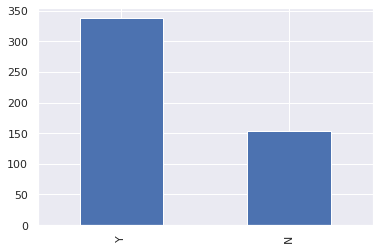

In [ ]:
train['Loan_Status'].value_counts().plot.bar() #creates a box plot for loan approvals
train['Loan_Status'].value_counts(normalize=True) #shows loan approvals

#A Look at the Categorical Variables
1. 80% of applicants are male and 20% are female
2. 65% of applicants are married and 35% are not
3. 15% of applicants are self employed and 85% are not
4. 85% of applicants have a credit history and 15% do not

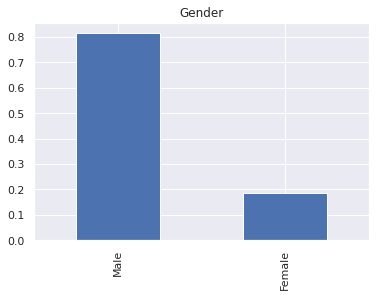

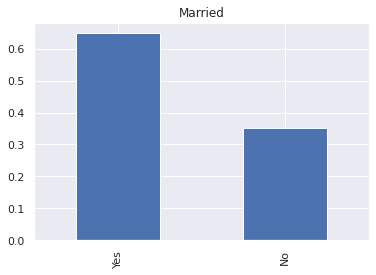

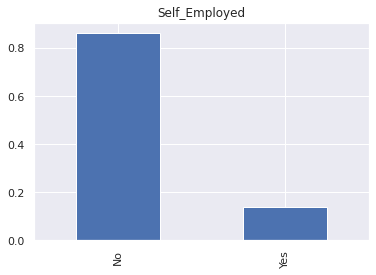

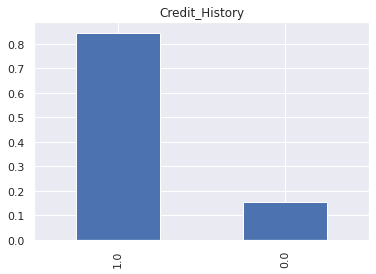

In [ ]:
#Bar plots for independent(categorical variables)
train['Gender'].value_counts(normalize=True).plot.bar(title='Gender')
plt.show()
train['Married'].value_counts(normalize=True).plot.bar(title='Married')
plt.show()
train['Self_Employed'].value_counts(normalize=True).plot.bar(title='Self_Employed')
plt.show()
train['Credit_History'].value_counts(normalize=True).plot.bar(title='Credit_History')
plt.show()

# A Look a the Ordinal Values
1. Most applicants have 0 dependents
2. Most applicants are graduates 
3. Most applicants are applying for loans for the suburbs

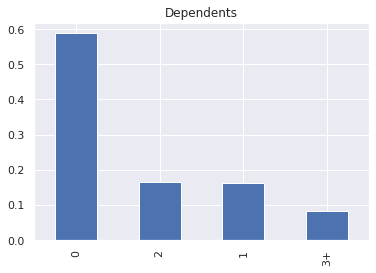

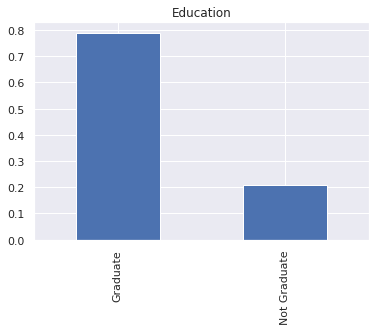

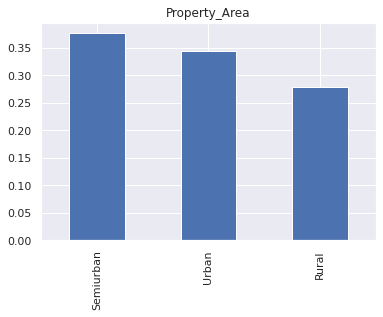

In [ ]:
#Bar plots for idependant(ordinal values)
train['Dependents'].value_counts(normalize=True).plot.bar(title='Dependents')
plt.show()
train['Education'].value_counts(normalize=True).plot.bar(title='Education')
plt.show()
train['Property_Area'].value_counts(normalize=True).plot.bar(title='Property_Area')
plt.show()

# Applicant Income
1. The distribution shows that there is a high level on income inequality where a few people have much more money than others. This also leads to some people applying for much higher loan amounts than others
2. Those who are college graduates earn more than non graduates and have a larger range of incomes due to outliers


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

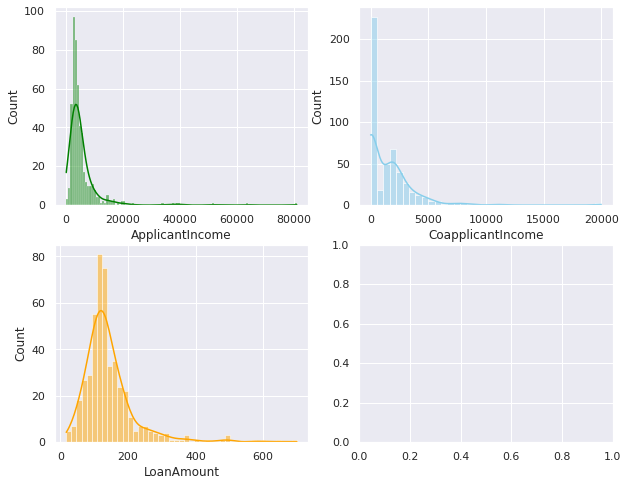

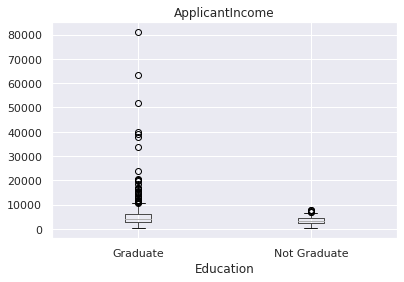

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=train['ApplicantIncome'], kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=train['CoapplicantIncome'],kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=train['LoanAmount'],kde=True, ax=axs[1, 0], color='orange')
train.boxplot(column='ApplicantIncome', by = 'Education') 
plt.suptitle("")

# Gender and Loan Status
Here we can see that there is some bias when it comes to loan acceptance based on gender. Males get approved for loans more than females do and when the amount of applicants increases that can lead to large disparities in home ownership. To address this bias we will train models that do not take gender into account. This is done because ideally gender is not an important factor when it comes to identifying loan eligibility


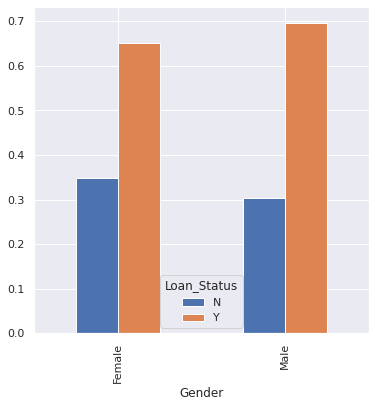

In [ ]:
Gender=pd.crosstab(train['Gender'],train['Loan_Status'])
Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar",stacked=False,figsize=(6,6))
plt.show()

# Credit History and Property Area on Loan Status
1. Applicant credit history seems to largely affect whether they get a loan or not. Applicants without a credit history rarely get accepted for loans, while applicants with credit history mostly do get accepted for loans
2. Applicants purchasing homes in surburban areas are more likely to get approved for their loans than applicants in rural or urban areas.

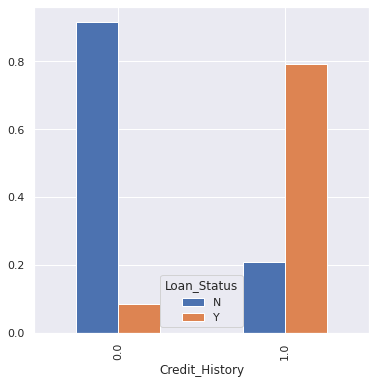

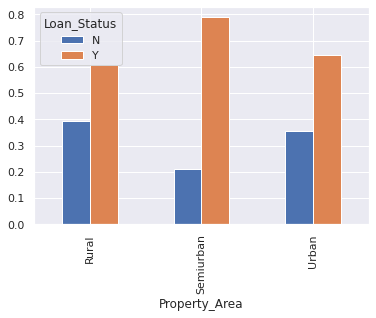

In [ ]:
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Property_Area=pd.crosstab(train['Property_Area'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar",stacked=False,figsize=(6,6))
plt.show()
Property_Area.div(Property_Area.sum(1).astype(float), axis=0).plot(kind="bar",stacked=False)
plt.show() 

#Heatmap
1. Credit History and Loan Status have a very high correlation
2. Loan Amount and Applicant income have the highest correlation
3. Loan Amount and CoApplicant income also have a high correlation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


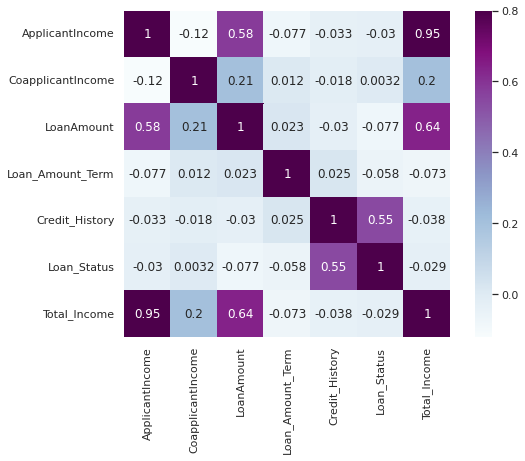

In [ ]:
#heatmap
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['Dependents'].replace('3+', 3,inplace=True)
test['Dependents'].replace('3+', 3,inplace=True)
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
matrix = train.corr()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap="BuPu", annot = True)

#Handling Null Values
1. For Categorical Variables replace nulls with the mode value
2. For Numerical Variables replace nulls with medians



In [ ]:
#all missing values in table
train.isnull().sum()

#using the mode of the features in Gender, Married, Dependents, Credit_History, and Self_Employed so we can fill empty values 
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)

#fill the missing values in Loan_Amount_Term
train['Loan_Amount_Term'].value_counts()
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

#fill the missing values in 'LoanAmount'
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

#check if any value still missing.
train.isnull().sum()

#fill all the missing values in the test dataset
test['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Married'].fillna(train['Married'].mode()[0], inplace=True)
test['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)


train['LoanAmount_log']=np.log(train['LoanAmount'])
test['LoanAmount_log']=np.log(test['LoanAmount'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

# Random Forest

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
train=train.drop('Loan_ID',axis=1)
test=test.drop('Loan_ID',axis=1)
y = train['Loan_Status']
X = train.drop('Loan_Status', axis = 1)
X = pd.get_dummies(X)
y = pd.get_dummies(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predict = RF.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = accuracy_score(y_predict,y_test)
print(f"{round(RF_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.72      0.54      0.62        24
           1       0.86      0.92      0.89        75

   micro avg       0.84      0.83      0.83        99
   macro avg       0.79      0.73      0.75        99
weighted avg       0.83      0.83      0.82        99
 samples avg       0.83      0.83      0.83        99

82.83% Accurate


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predict = DT.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        24
           1       0.85      0.83      0.84        75

   micro avg       0.76      0.76      0.76        99
   macro avg       0.67      0.68      0.68        99
weighted avg       0.76      0.76      0.76        99
 samples avg       0.76      0.76      0.76        99

75.76% Accurate


In [ ]:
Z = train.drop('Loan_Status', axis = 1)
Z = train.drop('Gender', axis = 1)
Z = pd.get_dummies(Z)
d = train['Loan_Status']
d = pd.get_dummies(d)
Z_train, Z_test, d_train, d_test = train_test_split(Z, d, test_size = 0.2, random_state = 0)

RF = RandomForestClassifier()
RF.fit(Z_train, d_train)

d_predict = RF.predict(Z_test)

#  prediction Summary by species
print(classification_report(d_test, d_predict))

# Accuracy score
RF_SC = accuracy_score(d_predict,d_test)
print(f"{round(RF_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        75

   micro avg       1.00      1.00      1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99
 samples avg       1.00      1.00      1.00        99

100.0% Accurate


In [ ]:
Z_train, Z_test, d_train, d_test = train_test_split(Z, d, test_size = 0.2, random_state = 0)
DT = DecisionTreeClassifier()
DT.fit(Z_train, d_train)

d_predict = DT.predict(Z_test)

#  prediction Summary by species
print(classification_report(d_test, d_predict))

# Accuracy score
DT_SC = accuracy_score(d_predict,d_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        75

   micro avg       1.00      1.00      1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99
 samples avg       1.00      1.00      1.00        99

100.0% Accurate
